### Checkpoint report due 23rd Mar

Slide Deck 10-15 Slides
1. Motivation (Stephen)
2. EDA (Sylvester/Stephen) 
3. Some first results (Jovi)
4. Obstacles/Questions (Just add on if you have any)
5. Next Steps (Jovi) 

For the code base:
1. Stephen - integrating Syl features, and running through the whole pipeline?
2. Sylvester - Fix the bug, sci-kit learn pipline 
3. Jovi - Come up with template for hyperparameter search, linear regression, LIME 

In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt 
from sklearn.model_selection import KFold, cross_validate

In [2]:
df = pd.read_csv('../data/processed/preprocessed_080321.csv')

In [3]:
# use resale price as the predictor for a start 

seed = 42
y = df['resale_price']
X = df.drop(columns=['resale_price', 'price_per_area', 'latitude', 'longitude'])
predictors = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [4]:
# use scaling to scale data, can be taken out if necessary - should compare performance before and after

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Base Model

In [26]:
rf = RandomForestRegressor(random_state=seed)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [27]:
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))

# I am pleased with the base model results. A percentage error of 6% is quite good performance. 

Mean Absolute Error: 17047.51993347166
Mean Absolute Percentage Error: 0.058315777025117616
Mean Squared Error: 630917142.4287264
Root Mean Squared Error: 25118.064066100444


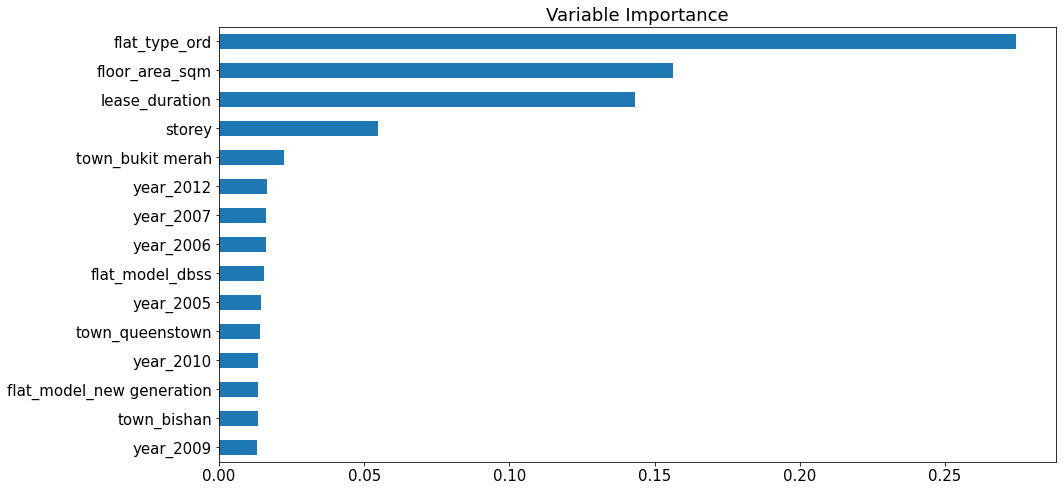

In [28]:
plt.rcParams["figure.figsize"] = (15, 8)
feat_imp = pd.Series(rf.feature_importances_, predictors).sort_values(ascending=True).tail(15)
feat_imp.plot(kind='barh')
plt.title('Variable Importance')
plt.show()

### Base Model on Test Data (Generating predictions)

In [29]:
df_test = pd.read_csv('../data/processed/preprocessed_test_170321.csv')
df_train = pd.read_csv('../data/processed/preprocessed_080321.csv')

In [31]:
seed = 42
y_train = df_train['resale_price']
X_train = df_train.drop(columns=['resale_price', 'price_per_area', 'latitude', 'longitude'])
predictors = X_train.columns
X_test = df_test[predictors]

# use scaling to scale data, can be taken out if necessary - should compare performance before and after
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [37]:
rf = RandomForestRegressor(random_state=seed)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [46]:
out = pd.DataFrame(data=y_pred).reset_index()
out.columns = ['Id', 'Predicted']
out.to_csv('../data/processed/submission_180321.csv', index=False)

In [49]:
out.shape

(107934, 2)

### Comparing different models with 10-fold cross validation

In [5]:
# df = df.sample(10000)
y = df['resale_price']
X = df.drop(columns=['resale_price', 'price_per_area', 'latitude', 'longitude'])

In [6]:
metrics = ['neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error']
cv_split = 10
models = []
models.append(('RF', RandomForestRegressor(random_state=seed)))
models.append(('GB', GradientBoostingRegressor(random_state=seed)))
models.append(('EN', ElasticNet(random_state=seed)))
models.append(('LR', LinearRegression))

names = []
mape_list = []
rmse_list = []

for name, model in models:
    cv_score = cross_validate(model, X, y, cv=cv_split, n_jobs=2, scoring=metrics)
    mape = cv_score['test_neg_mean_absolute_percentage_error'] * -1
    rmse = cv_score['test_neg_root_mean_squared_error'] * -1
    mape_list.append(mape)
    rmse_list.append(rmse)
    names.append(name)
    msg = f'{name} mape: {mape.mean():.3f} (range {mape.min():.3f}-{mape.max():.3f})'
    print(msg)
    msg = f'{name} rmse: {rmse.mean():.3f} (range {rmse.min():.3f}-{rmse.max():.3f})'
    print(msg)

RF mape: 0.058 (range 0.058-0.058)
RF rmse: 24960.025 (range 24635.109-25267.542)
GB mape: 0.135 (range 0.134-0.136)
GB rmse: 54417.759 (range 53409.370-54917.132)
EN mape: 0.261 (range 0.259-0.262)
EN rmse: 92651.307 (range 91551.576-93386.257)


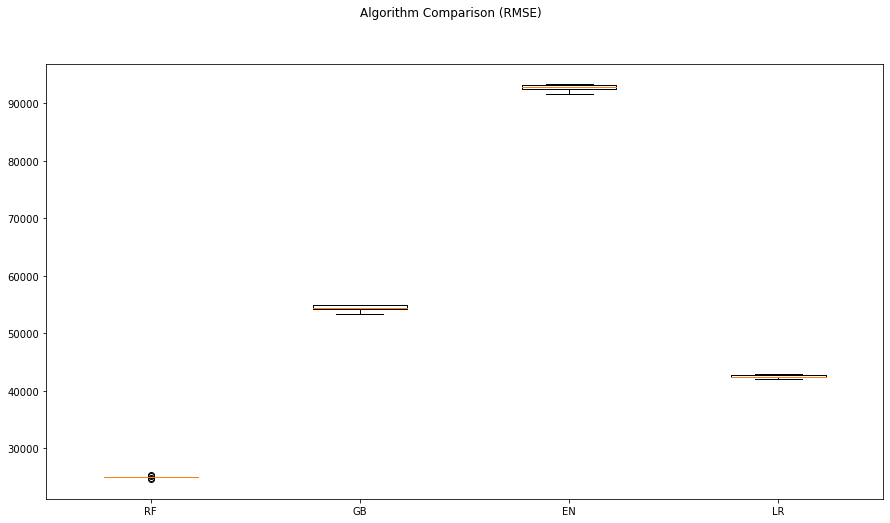

In [15]:
plt.rcParams["figure.figsize"] = (15, 8)
fig = plt.figure()
fig.suptitle('Algorithm Comparison (RMSE)')
ax = fig.add_subplot(111)
plt.boxplot(rmse_list)
ax.set_xticklabels(names)
plt.show()

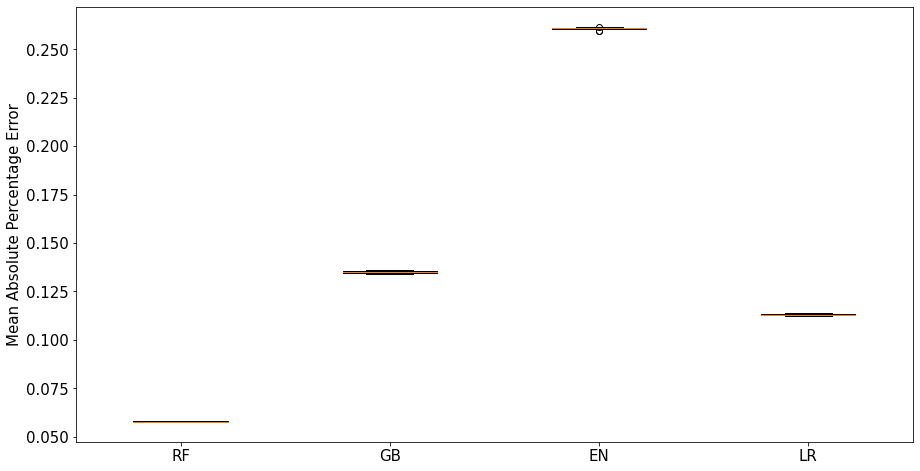

In [22]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(mape_list)
ax.set_xticklabels(names)
plt.ylabel('Mean Absolute Percentage Error')
plt.show()